# Lab04 - 0D Climate Model - Lab Bench

Load relevant packages with the code below and check to make sure you are working in the right directory.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%%capture
%pip install ipympl
# %pip install matplotlib --upgrade

In [ ]:
# Imports used throughout the lab (arrays, plotting, data frames, ODE integration)
from pathlib import Path

import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

try:
  plt.style.use('bmh')
except:
  print('normal plotting style')

import pandas as pd
import seaborn as sns
from scipy.integrate import solve_ivp
from datetime import datetime

notebook_loc = Path(os.getcwd())
# check that has the right parent
if notebook_loc.parent.name != 'work':
  print('Please make a copy of this notebook and put it in your "work" folder!')
else:
  fig_dir = notebook_loc/'figures'
  fig_dir.mkdir(parents=True, exist_ok=True)
  print('Great, your figures will be saved in:', fig_dir)


def fig_save(fig_name, filetype='png'):
  fig_path = fig_dir/f'{fig_name}.{filetype}'
  unique_fig_path = fig_dir/f'{fig_path.name}__{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}{fig_path.suffix}'
  plt.savefig(fig_path, dpi=300)
  plt.savefig(unique_fig_path, dpi=300)



if (notebook_loc/'support_code').exists() is True:
  sys.path.append(str(notebook_loc/'support_code/CoursewareModules'))
  sys.path.append(str(notebook_loc/'support_code'))

from ClimateUtilities import *  # import Ray Pierrehumbert's climate utilities
import phys
import seaborn as sns
from tools import *

%matplotlib inline

## Part 1: Zero-D Climate ($T_e = T_s$, constant $L$)

Our task is to describe climate using a zero-dimensional energy balance model. The system has a single state variable, temperature, and evolves according to conservation of energy: the rate of change of internal energy equals energy gained minus energy lost. As in the box models, the key questions are whether equilibria exist, whether they are stable, and how feedbacks shape system behavior.

The dynamics follow directly from conservation of energy and take the form of an ordinary differential equation:

Here, $T$ is the system temperature and the albedo, $\alpha(T)$, is a nonlinear function of climate state. In Part 1, we treat the system as a single-temperature model. This is equivalent to assuming emission temperature and surface temperature are the same (i.e., no greenhouse effect). In Part 2, we relax that assumption.

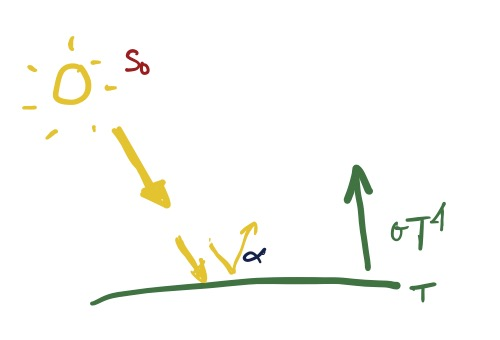

### Piece by piece

The left-hand side, $C_s \frac{dT}{dt}$, represents the rate of change of the system’s internal energy. The parameter $C_s$ is an effective heat capacity of the Earth system, so this term determines how quickly temperature responds to an energy imbalance.

The right-hand side represents a balance between incoming shortwave radiation from the Sun, $(1 - \alpha(T)) \frac{S_{\circ}}{4}$, and outgoing longwave radiation from the Earth, $\sigma T^4$.

As in the box models, change is driven by imbalance. Here, temperature evolves according to the difference between absorbed solar energy and emitted infrared energy. The functional forms are more nonlinear than in our earlier linear exchange examples, but the structural idea is the same.

Let’s unpack some of these quantities.

Briefly, what underpins the fact that the Sun emits shortwave radiation and the Earth emits longwave radiation?

#### Incoming solar radiation

The Earth receives shortwave radiation from the Sun. What happens to it?

If we multiply this out,

we see that the contribution of the Sun to Earth’s energy budget is set by the solar constant, but only a fraction is absorbed. The albedo term determines how much is reflected back to space.

**WS-Q:** What units are being used for temperature? What are the units of albedo? What does the albedo term mean? What does it mean for incoming solar radiation if albedo = 1? If albedo = 0?

It is a strong simplification to collapse Earth’s albedo into a single function of temperature, but that is necessary in a 0D model. We define albedo as a function of temperature, $\alpha(T)$:

<br>

#### Outgoing longwave radiation

Outgoing longwave emission from the planet is given by $\sigma T^4$. What does this represent?

**WS-Q:** What is the difference between the process by which albedo reflects a fraction of incoming shortwave radiation and the process by which the Earth emits longwave radiation to space?

### The 0D Climate Model v.1

Here is the Python implementation of the albedo function. (Remember to run the cell so the function is stored in memory. Not all cells produce output.)

In [ ]:
def albedo(T):
    if T < T1:
        return alpha_ice
    elif (T >= T1)&(T<=T2):
        r = (T-T2)**2/(T2-T1)**2
        return alpha_0 + (alpha_ice - alpha_0)*r
    else:
        return alpha_0

Now we define a helper function to compute outgoing longwave radiation (OLR) from temperature. This implementation is designed to be flexible so we can reuse it in Part 2. For now, it assumes $T_e = T$.

In [ ]:
def OLR(T, pRad=None, ps=1000):
    if pRad is None:
        Te = T
    else:
        Te = (pRad/ps)**(2./7.)*T  # Part 2: connect surface T to emission T
    return phys.sigma * (Te**4.)

Below, we build a simulation function that combines albedo and OLR to calculate fluxes. Again, we are not integrating in time. We are operating entirely in temperature space. It is natural to think in terms of time evolution, but in this model all behavior is determined by temperature.

In [ ]:
def sim_OLR(L=1370, alpha_ice=.6, alpha_0=.1, T1=260., T2=290, pRad=None, Tlist = None):

    def albedo(T):
        if T < T1:
            return alpha_ice
        elif (T >= T1)&(T<=T2):
            r = (T-T2)**2/(T2-T1)**2
            return alpha_0 + (alpha_ice - alpha_0)*r
        else:
            return alpha_0

    if Tlist is None: 
        Tlist = [200.+ 2.*i for i in range(70)]
    SabsList = []
    OLRlist = []
    NetFluxlist = []
    Glist = []
    aList = []

    for T in Tlist:
        aList.append(albedo(T))  # albedo function
        SabsList.append((L/4.)*(1.-albedo(T))) # incident solar values
        OLRlist.append(OLR(T,pRad=pRad)) # outgoing longwave emissions
        NetFluxlist.append((L/4.)*(1.-albedo(T)) - OLR(T,pRad=pRad))  # net flux
        Glist.append(4.*OLR(T,pRad=pRad)/(1.-albedo(T)))  # balance function

    d = {'Tlist':Tlist, 'SabsList':SabsList, 'OLRlist':OLRlist, 'NetFluxlist':NetFluxlist,
         'Glist':Glist, 'aList':aList, 'Llist':[L for ik in range(len(aList))]}

    return d

Notice that the function takes six arguments: L, alpha_ice, alpha_0, T1, T2, and pRad. Default values are provided. In the next questions, you will vary these parameters to explore how the system responds.

The next cell generates lists of absorbed shortwave radiation, OLR, and net flux for temperatures ranging from 200 to 340 K, using default parameter values.

In [ ]:
Tlist = [200.+ 2.*i for i in range(70)]
d = sim_OLR(**{'L':1370, 'Tlist':Tlist})

To build some intuition for the most concrete aspect of this system, let’s look at albedo as a function of temperature. In the real world, there would be some time that would pass as the system adjusted to its new state, but this plot summarizes the relationship between albedo and temperature after that adjustment period.

Plot the albedo curve as a function of temperature.

In [ ]:
%matplotlib inline
plt.close()
c1 = Curve()
c1.addCurve(d['Tlist'])
c1.addCurve(d['aList'],'Albedo','Alb')
c1.Xlabel = 'Temperature (K)'
c1.Ylabel = 'Alpha'
c1.PlotTitle = 'Planetary Albedo'
w1 = plot(c1)

**WS-Q:**

What is the role of the two parameters, `T1` and `T2`? (We left them at their default values, 260 and 290). What are the dominant values for albedo?

### Energy Balance

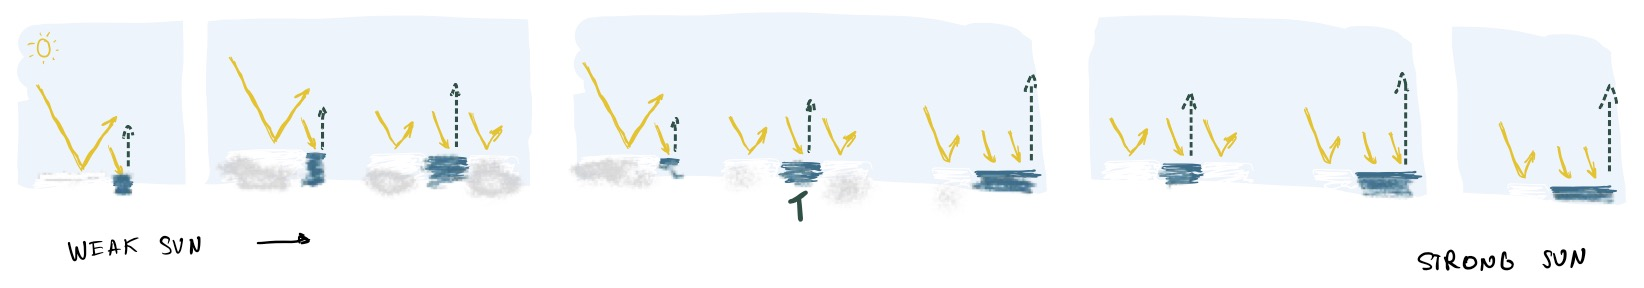

------------------------------------------------------------------------

Recap:

What we know so far:

1.  The rate of energy change depends on absorbed shortwave radiation minus outgoing longwave radiation.
2.  Both terms depend on temperature, the state variable of the system.

------------------------------------------------------------------------

Let’s look directly at energy balance: what is coming in, and what is going out?

When we run `sim_OLR`, we compute values for albedo at each temperature, absorbed shortwave radiation, outgoing longwave radiation, and net flux — all evaluated across a range of temperature states. By plotting absorbed shortwave and emitted longwave together, we can identify the conditions under which the system is balanced.

Use the code below to plot absorbed shortwave radiation and emitted longwave radiation.

In [ ]:
L_list = [1370]

plot_energy_balance(sim_OLR, param_name='L', y_var='SabsList', x_var='Tlist', x_label=None, y_label='Flux',
                        param_list=L_list, figsize=(5, 5))

When examining energy balance, we are plotting the incoming and outgoing fluxes calculated over the same range of temperatures. The y-axis represents energy flux (energy per unit area per unit time). The key feature is where the curves intersect.

Where is the system in balance?

**WS-Q:** Where is the system in balance?

------------------------------------------------------------------------

------------------------------------------------------------------------

## Part 2: Control parameters

So far, we have treated parameters in our model as fixed constants. But we can learn a great deal about a system by examining how it responds when those constants change.

When a parameter is not state dependent, but can take on different prescribed values, we refer to it as a **control variable**. It is not determined by the system state, but it influences the system’s behavior. We vary it intentionally to explore how the system responds.

Let’s start with the solar luminosity “constant.” In reality, we suspect it has varied over time. Let’s examine how changing it affects the model.

### Luminosity as a control parameter

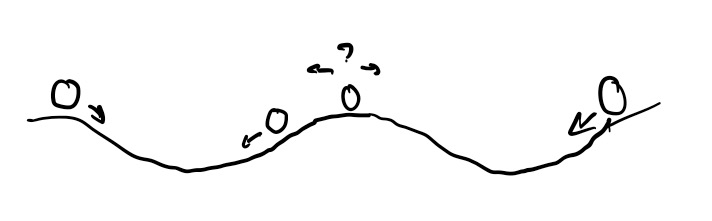

#### Energy Balance (again)

As a first step, revisit the code used to calculate energy balance. This time, run it for a list of solar luminosity values, $L$.

Plot absorbed solar radiation for different solar luminosities.

In [ ]:
L_list = [1370, 1685, 1854, 2865]
plot_energy_balance(sim_OLR, param_name='L', y_var='SabsList', x_var='Tlist', x_label=None, y_label='Flux',
                        param_list=L_list, figsize=(5, 5))

**Q:** Describe this figure.

-   What do the colored lines represent?
-   What does the bold dashed black line represent?
-   How do the relationships between the colored lines and the black line vary? (Hint: compare these cases to the single-$L$ case from the previous section.)

#### Stability

------------------------------------------------------------------------

Recap:  
Previously, you examined the individual flux terms as functions of temperature.

------------------------------------------------------------------------

Another way to analyze the system is to plot the difference between absorbed shortwave radiation and outgoing longwave radiation — the function we called $G(T)$. This produces what is known as a **stability diagram**. We use stability diagrams to identify and characterize fixed points.

A stability diagram plots the rate of change of a state variable against the state variable itself.

**Important distinction:** When we analyzed the spring, we plotted $dx/dt$ versus $x$ and called it a phase portrait. Why is this different?

In the spring system, position ($x$) and velocity ($dx/dt$) are independent state variables because the system is second order. A phase portrait shows how multiple state variables co-evolve through time.

In this energy balance model, temperature ($T$) is the only state variable. The net flux determines $dT/dt$, but $dT/dt$ is not an independent coordinate of the system. When we plot $dT/dt$ versus $T$, we are visualizing the tendency of the system across possible temperature states — not the time evolution of two independent variables.

Plot the net flux and the zero line to visualize equilibria.

In [ ]:
c2 = Curve()
c2.addCurve(d['Tlist'])
c2.addCurve(d['NetFluxlist'],'Net','Net Flux')
c2.addCurve([0. for i in range(len(d['Glist']))],'Zero','Equilibrium')
c2.Xlabel = 'Temperature (K)'
c2.Ylabel = 'Net Flux ($W/m^2$)'
c2.PlotTitle = 'Stability diagram'
w2 = plot(c2)

**Q:**

-   What are the quantities on the x and y axes in a stability diagram?  
-   What does it mean when the curve is above the zero line? Below?  
-   How is a stability diagram different from a phase portrait?

What does it mean when there are multiple equilibria? Think back to the undamped pendulum and its two fixed points.

##### Explore

We are building toward a picture of how system stability changes as we vary a control parameter like the solar luminosity. The stability diagram you just produced gave a first glimpse, but here we want the bigger picture.

Launch the stability exploration widget below to map equilibria across $L$. Clicking the mini plot below the main figure will add a curve showing Net Flux versus temperature for the selected value of $L$.

In [ ]:
%matplotlib widget

make_stability_bifurcation(sim_OLR, bifurcation=False, bifurcation_title='Temp(s) which could be\nequilibrium states for each L')

**Q:** Based on your plot, for which ranges of the solar luminosity ($L$) do we get 1, 2, or 3 equilibria?

#### Charting balance

------------------------------------------------------------------------

Recap:

You now have a sense that, for a given value of the solar luminosity, the system can have one or more equilibria, and those equilibria can differ in stability.

Can we map the relationship between $L$, temperature, and equilibrium?

------------------------------------------------------------------------

**Q:**

Setting $G(T) = 0$, derive an analytical expression for $L_{eq}$, the value of $L$ for which incoming solar radiation balances exactly outgoing longwave radiation. Hint: you’re looking for an expression of the form $L = \dots$

Use the bifurcation widget below to map equilibrium temperatures versus $L$. Clicking the right subplot will select values of $L$. Those values are then used to calculate (1) net flux curves in the stability plot on the left (as before) and (2) equilibrium points in the subplot on the right.

In [ ]:
%matplotlib widget
make_stability_bifurcation(sim_OLR, bifurcation=True, bifurcation_title='')

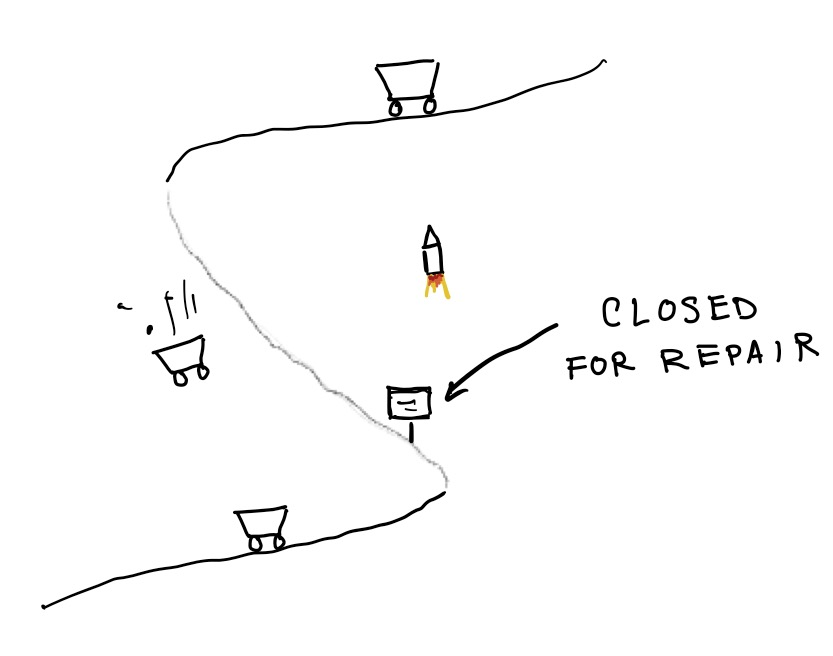

What you just did, informally (first in terms of parameter ranges describing the number of equilibrium states) and then via the scatterplot, is to draw a **bifurcation diagram** for the system.

The function you derived above by setting $G(T) = 0$ and solving for $L$ as a function of $T$ is a balance function. It tells us about the combinations of values that correspond to a system in equilibrium.

In reality, $T$ is a consequence of the value of $L$ (or $p_{\text{rad}}$), not a driver of it (so “L as a function of T” is mathematically accurate to describe the function you derived, but not an appropriate description of the underlying dynamics). Let’s reorganize so that the independent variable is on the X axis and the dependent variable is on the Y axis, which is to say, we get $T = f(L)$, not $L = f(T)$.

Plot a bifurcation diagram in terms of solar luminosity and surface temperature.

In [ ]:
%matplotlib inline

L = 1000
pRad = 670
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()

d_L1 = sim_OLR(L=L,pRad=pRad)

c3 = Curve()
c3.addCurve(d_L1['Tlist'])
c3.addCurve(d_L1['Glist'],'G','Balance Function')
c3.addCurve(d_L1['Llist'],'S','Incident Solar')
ax.plot(c3.data['G'], c3.data['v0'], color='b', label='Balance function')
ax.axvline(x=d_L1['Llist'][0], ls='--', color='g', alpha=.5, label='L={}'.format(str(L)))

left, bottom, width, height = (1650, 260, 950, 20)
#left, bottom, width, height = (1050, 260, 600, 20)

rect = plt.Rectangle((left, bottom), width, height,
                     facecolor="black", alpha=0.1)

ax.add_patch(rect)
ax.set_title('Bifurcation diagram, pRad = %i mb'% int(pRad))
ax.set_ylabel('Surface Temperature (K)')
ax.set_xlabel('Solar luminosity ($W/m^2$)')
ax.legend(bbox_to_anchor=(1,1))

Once again, wherever this balance function (blue curve) intersects the incident solar radiation (dashed green curve), we get one or more equilibrium temperature(s). From this it is easy to find the values of the solar constant for which we can have 1, 2 or 3 equilibria. Note that some of the branches in this diagram are unstable.

**Q:**

In words, what is happening in this figure? Suppose you jumped on the curve when $L=1000$, and then $L$ began to increase (think: people-mover or escalator). What kind of ride would you experience through temperature space? How would it compare to the experience you would have if you jumped on when $L=2000$ and $L$ began to decrease?

**Q:**

A bifurcation point is a point where a change in a parameter causes the system to go from stable to unstable (or vice versa). Where are the bifurcation points? Now that you’ve had a first look at it, reposition the gray box by changing the values for `left, bottom, width, height` so that it bounds the unstable arm. This is one reason why bifurcations are relevant to climate risk assessment.

This is an interesting visualization of bifurcation space. ![](https://ars.els-cdn.com/content/image/1-s2.0-S0148296306000610-gr1.gif)

**Q:**

Pulling it all together, what ranges of $L$ would you confidently associate with an ice house climate and what ranges would you associated with a hothouse climate? What is the mechanism that mediates the transition between these two states in our model? Give and explain an example of how this might present for the shift from hothouse to ice house, and vice versa. Hint: thinking about the feedbacks that came up in lecture is one place to start.

------------------------------------------------------------------------

------------------------------------------------------------------------

### Greenhouse Effect ($T_e \ne T_s$)

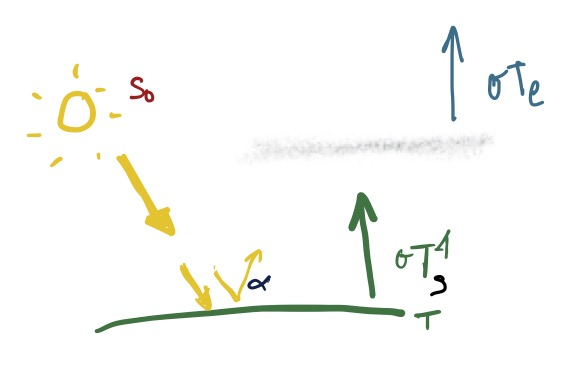

So far, we have treated the planet as a single-temperature body, which is equivalent to assuming the surface temperature equals the emission temperature ($T_s = T_e$). In reality, these differ because the atmosphere absorbs and re-emits infrared radiation.

A simple way to represent this is to introduce a *radiating pressure* $p_{rad}$: the pressure level from which Earth effectively emits to space. Smaller $p_{rad}$ corresponds to a higher emission altitude (and typically a stronger greenhouse effect).

In this model, we connect surface temperature $T_s$ to emission temperature $T_e$ using

$$
T_s = T_e \left(\frac{p_s}{p_\text{rad}} \right)^{\kappa}, \qquad \kappa = \frac{2}{7}.
$$

We will not fully explore this “second knob” here, but we will use it once to preview a key idea: **tipping thresholds can depend on more than one control variable.**

------------------------------------------------------------------------

#### Neoproterozoic thought experiment (two knobs)

Assume: - Modern-like greenhouse strength: $p_{rad} = 670$ mb (fixed), - A reduced solar luminosity during the Neoproterozoic: $L_{neo} = 0.93\,L_0$.

The question: *in this toy model, is a 7% drop in $L$ enough to push the climate past a tipping point into the cold state, given the same greenhouse strength?*

Use the bifurcation widget to explore equilibrium temperature versus $L$ at fixed $p_{rad} = 670$ mb.

In [ ]:
%matplotlib widget

def sim_OLR_prad(L=1370, alpha_ice=.6, alpha_0=.1, T1=260., T2=290, Tlist=None):
    return sim_OLR(L=L, alpha_ice=alpha_ice, alpha_0=alpha_0, T1=T1, T2=T2, pRad=670, Tlist=Tlist)

make_stability_bifurcation(sim_OLR_prad, bifurcation=True, bifurcation_title='Equilibrium temperature(s) vs L (fixed $p_{rad}=670$ mb)')

------------------------------------------------------------------------